# Imports

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import uniform

# Globals

In [175]:
## Population Descriptors
g = {
    'm': 10,
    'c': 10**6,
    'r': range(100, 525, 25),
    'v': range(2,20,4),
    's': 200
}

## Create Synthetic Populations
p = {
    'norm': norm.rvs(g['m'], 1, g['c']),
    'gamma': gamma.rvs(1, g['m']-1, 1, g['c']),
    'uniform': uniform.rvs(g['m']-3**(1/2),2*3**(1/2), g['c'])
}

# Visualise Populations

==Distribution: norm, Mean: 10.0, Std: 1.0==
==Distribution: gamma, Mean: 10.0, Std: 1.0==
==Distribution: uniform, Mean: 10.0, Std: 1.0==


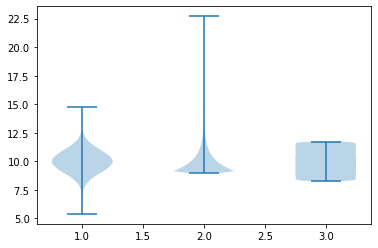

In [167]:
plot_data = []
for d in p.keys():
    plot_data.append(p[d])
    print("==Distribution: {}, Mean: {}, Std: {}==".format(d, round(p[d].mean(),2), round(p[d].std(),2)))
    
plt.violinplot(plot_data)
plt.show()

# Calculated Error

[1] $$error = Z\sqrt{\left(1-\frac{samplesize}{populationsize}\right)\frac{variance}{samplesize}}$$

In [168]:
def zscore(alpha):
    return norm.ppf(1-(alpha/2))
    
def error(population, samples, std, alpha):
    samples = np.array(samples)
    
    f = 1-samples/population
    c = zscore(alpha)
    s = (std**2)/samples
    return c*(f*s)**(1/2)

# Random Sampling

In [86]:
#Random Sampling Simulation
sim = dict()
for d in p.keys():
    sim[d] = []
    for s in g['r']:
        temp=[]
        for i in range(1000):
            ## Repeat 1000 times - take a sample of size s, calculate mean and store.
            temp.append(np.random.choice(p[d], size=s, replace=False).mean())
        # Save standard deviation of the mean estimate
        sim[d].append(np.array(temp).std())

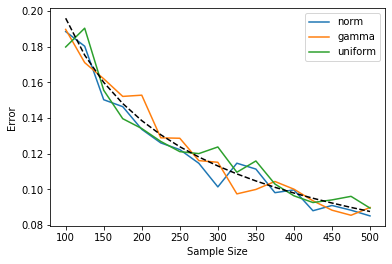

In [102]:
for d in p.keys():
    plt.plot(g['r'],[x*1.96 for x in sim[d]])
plt.plot(g['r'], error(g['c'], g['r'], 1, 0.05), ls='--', color='black')
plt.xlabel("Sample Size")
plt.ylabel("Error")
plt.legend(p.keys())

The distribution of the input data doesnt effect the size of the error as the distribution of the mean estimate converges to normal (central limit theorm). The simulated error follows what would be expected by simple calculation (1).

## The Bootstrap

Actual survey data doesnt have the convience of resampling from the population to explore error in the mean estimate. Where simple calculation [1] is not appropriate the bootstrap method can be employed where resampling is based on the single obtained sample. Below will compare the results from calculation, simulation and bootstrap with 200 samples (using the population gamma distribution above).

In [169]:
print("==Simple calculation: {}+-{}==".format(g['m'],round(error(g['c'], g['s'], 1, 0.05),3)))

==Simple calculation: 10+-0.139==


In [170]:
sim["s200"] =[]
boots = {
    'm': [],
    's':[]
}
for i in range(1000):
    sample = np.random.choice(p['gamma'],size=g['s'],replace=False)
    ## Used for population resampling simulation
    sim["s200"].append(sample.mean())
    ## Apply bootstrap on this single sample
    temp=[]
    for i in range(5000):
        temp.append(np.random.choice(sample, size=len(sample),replace=True).mean())
    temp=np.array(temp)
    boots['m'].append(temp.mean())
    boots['s'].append(temp.std())

#convert lists to arrays
sim["s200"] = np.array(sim["s200"])
for k in boots.keys():
    boots[k] = np.array(boots[k])
    
print("==Simulation: {}+-{}==".format(np.round(sim["s200"].mean(),2),np.round(sim["s200"].std()*zscore(0.05),3)))

==Simulation: 10.0+-0.139==


==Simulation: 10.0+-0.137==


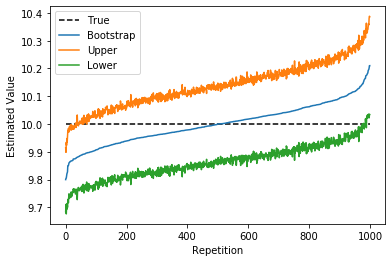

In [171]:
b = pd.DataFrame([boots["m"], boots["s"]], ["m", "s"]).T
b.sort_values(by='m',inplace=True)

##Create confidence intervals
b['ci'] = b['s'] * zscore(0.05)
for v, m in zip(['l','u'],[-1,1]):
    b[v] = b['m'] + (b['ci']*m)

##Plot upper and lower bounds
plt.plot([0,1000], [g['m']]*2, color='black', ls="--")
for v in ['m', 'u', 'l']:
    plt.plot(range(len(b)), b[v])
plt.legend(["True", "Bootstrap", "Upper", "Lower"])
plt.xlabel("Repetition")
plt.ylabel("Estimated Value")

print("==Simulation: {}+-{}==".format(np.round(b['m'].mean(),2),np.round(b["ci"].mean(),3)))

In [172]:
print("Proportion of repetitions which dont capture the true mean: {}%".format(100*(sum(b['l'] > g['m']) + sum(b['u']<g['m']))/1000))

Proportion of repetitions which dont capture the true mean: 5.6%


## Changing Variance

In [183]:
## Add additional normal distributions with different variance
for i in g['v']:
    p['norm{}'.format(i)] = norm.rvs(g['m'], 1*i, g['c'])
k = [x for x in p.keys() if 'norm' in x]

In [178]:
sim2 = dict()
for d in k:
    sim2[d] = []
    for s in g['r']:
        temp=[]
        for i in range(1000):
            ## Repeat 1000 times - take a sample of size s, calculate mean and store.
            temp.append(np.random.choice(p[d], size=s, replace=False).mean())
        # Save standard deviation of the mean estimate
        sim2[d].append(np.array(temp).std())

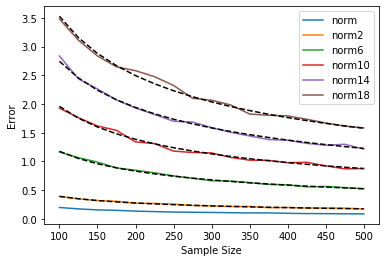

In [184]:
#Plot simulated error
for d in k:
    plt.plot(g['r'],[x*1.96 for x in sim2[d]])
#Plot Calculated Errors
for i in g['v']:
    plt.plot(g['r'], error(g['c'], g['r'], i, 0.05), ls='--', color='black')

plt.xlabel("Sample Size")
plt.ylabel("Error")
plt.legend(k)